In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

Training samples: 9194
Validating samples: 1666
Testing samples: 879


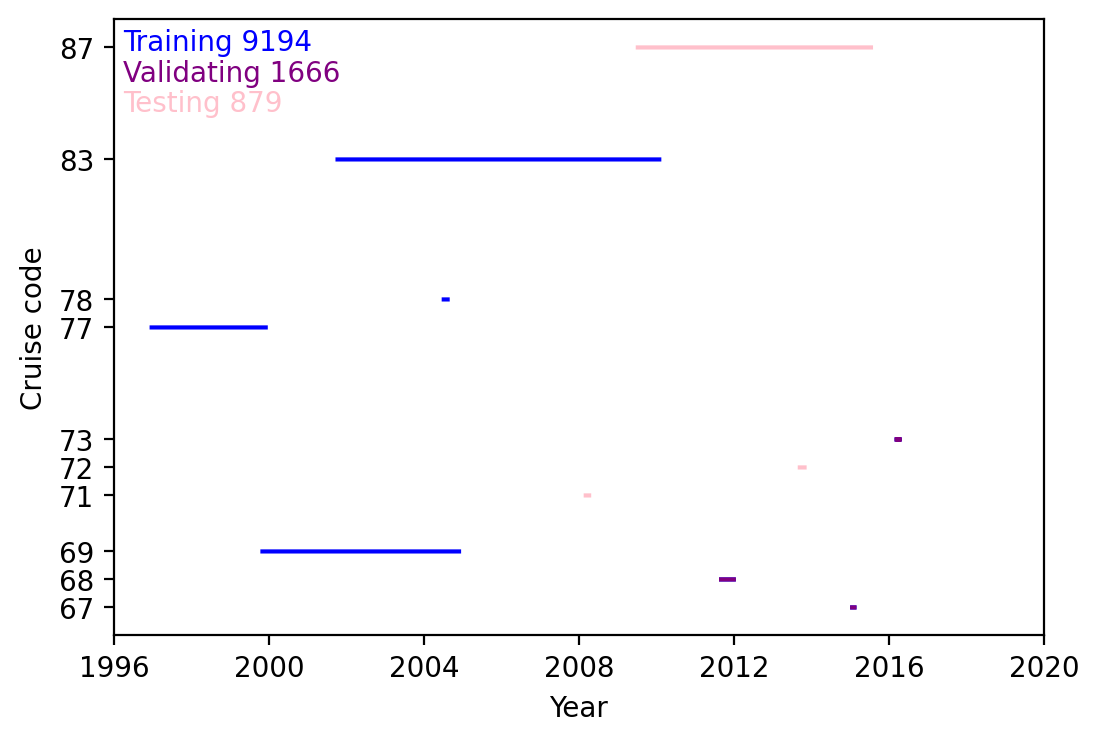

In [2]:
psd = xr.load_dataset('../../data/Processed/psd.nc')
from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

# split=[[77, 69, 83, 78], [87, 72, 71], [68, 67, 73]]
split=[[77, 69, 83, 78, 68, 67, 73], [68, 67, 73], [87, 72, 71]]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=True, XVIS='time')

### 1.1 - Three input, make an additional linear transform layer

In [3]:
from mlflux.ann import ANN
import torch.nn as nn

class ANNdiff(ANN):
    def __init__(self, n_in=3, n_out=1, hidden_channels=[24, 24], degree=None):
        super().__init__(n_in, n_out, hidden_channels, degree)
        self.degree = degree # But not necessary for this application
    
        layers = []
        fixed_layer = nn.Linear(n_in, n_in+1, bias=False)
        weights = torch.tensor(np.array([[1,0,0],[0,1,0],[0,0,1],[0,1,-1]]).astype('float32')) # The additional variable takes the difference of the temperature
        fixed_layer.weight = nn.Parameter(weights,requires_grad=False)
        layers.append(fixed_layer) # Only works when inputs are U-Tsea-Tair
        layers.append(nn.Linear(n_in+1, hidden_channels[0]))
        layers.append(nn.Sigmoid())
        
        for i in range(len(hidden_channels)-1):
            layers.append(nn.Linear(hidden_channels[i], hidden_channels[i+1]))
            layers.append(nn.Sigmoid())
            
        layers.append(nn.Linear(hidden_channels[-1], n_out))
        
        self.layers = nn.Sequential(*layers)

class Flux31(FluxANNs):
    
    def __init__(self, params={}):
        super().__init__(params)
        # Check that it has all the parameters
        if not hasattr(self, "mean_ann_para"):
            raise ValueError('Need to define ANN parameters for mean!')
        if not hasattr(self, "var_ann_para"):
            raise ValueError('Need to define ANN parameters for var!')
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2
        scale = torch.tensor(np.array([20,1,1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([-8]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([20.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    # def evaluate_uniform(self):
    #     x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
    #     x1_mesh, x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')
    #     X_uniform = np.hstack([x1_mesh.reshape(-1,1), x2_mesh.reshape(-1,1)])
    #     X_uniform = torch.tensor(X_uniform.astype('float32'))
    #     mean_uniform = self.pred_mean(X_uniform).detach().reshape(100,100)
    #     var_uniform = self.pred_var(X_uniform).detach().reshape(100,100)
    #     return (mean_uniform, var_uniform)
    

In [10]:
para1 = {'n_in':3,'n_out':1,'hidden_channels':[16,16]}
para2 = {'n_in':3,'n_out':1,'hidden_channels':[16,16]}
model = Flux31({'mean_ann_para':para1, 'var_ann_para':para2})

def sample_weights (x):
    return np.where(x > 18., 1.0, 1.0)

# from mlflux.ann import sample_weights

# Initiate the Dataset class and use default weighting
training_data = RealFluxDataset(training_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)
testing_data = RealFluxDataset(testing_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)

training_paras = {'batchsize':100, 'num_epochs':400, 'lr':5e-3, 'gamma':0.2}
log, training_data_cp = model.fit(training_data,validating_data,training_paras)

Epoch [1/400], Loss: 1612.68683130
Epoch [2/400], Loss: 366.76506707
Epoch [3/400], Loss: 284.66547325
Epoch [4/400], Loss: 203.76514603
Epoch [5/400], Loss: 171.64064518
Epoch [6/400], Loss: 149.74212661
Epoch [7/400], Loss: 135.49033781
Epoch [8/400], Loss: 124.82592280
Epoch [9/400], Loss: 117.20861322
Epoch [10/400], Loss: 110.65563136
Epoch [11/400], Loss: 105.44431366
Epoch [12/400], Loss: 99.80619381
Epoch [13/400], Loss: 94.48459121
Epoch [14/400], Loss: 90.07312602
Epoch [15/400], Loss: 86.01773311
Epoch [16/400], Loss: 81.99943359
Epoch [17/400], Loss: 79.29401122
Epoch [18/400], Loss: 75.31348500
Epoch [19/400], Loss: 72.10331362
Epoch [20/400], Loss: 68.86785113
Epoch [21/400], Loss: 67.30964616
Epoch [22/400], Loss: 63.79196980
Epoch [23/400], Loss: 61.73303762
Epoch [24/400], Loss: 59.52368947
Epoch [25/400], Loss: 56.91907121
Epoch [26/400], Loss: 55.67785533
Epoch [27/400], Loss: 53.93498089
Epoch [28/400], Loss: 52.45935387
Epoch [29/400], Loss: 51.91496660
Epoch [30/4

In [1]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
# axes[0].set_ylim([-4000,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])
axes[2].plot(log['training_mse'], label='Training data')
axes[2].plot(log['validating_mse'], label='Validating data')
axes[2].set_ylabel(r'$MSE$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].set_ylim([0,1])

NameError: name 'plt' is not defined

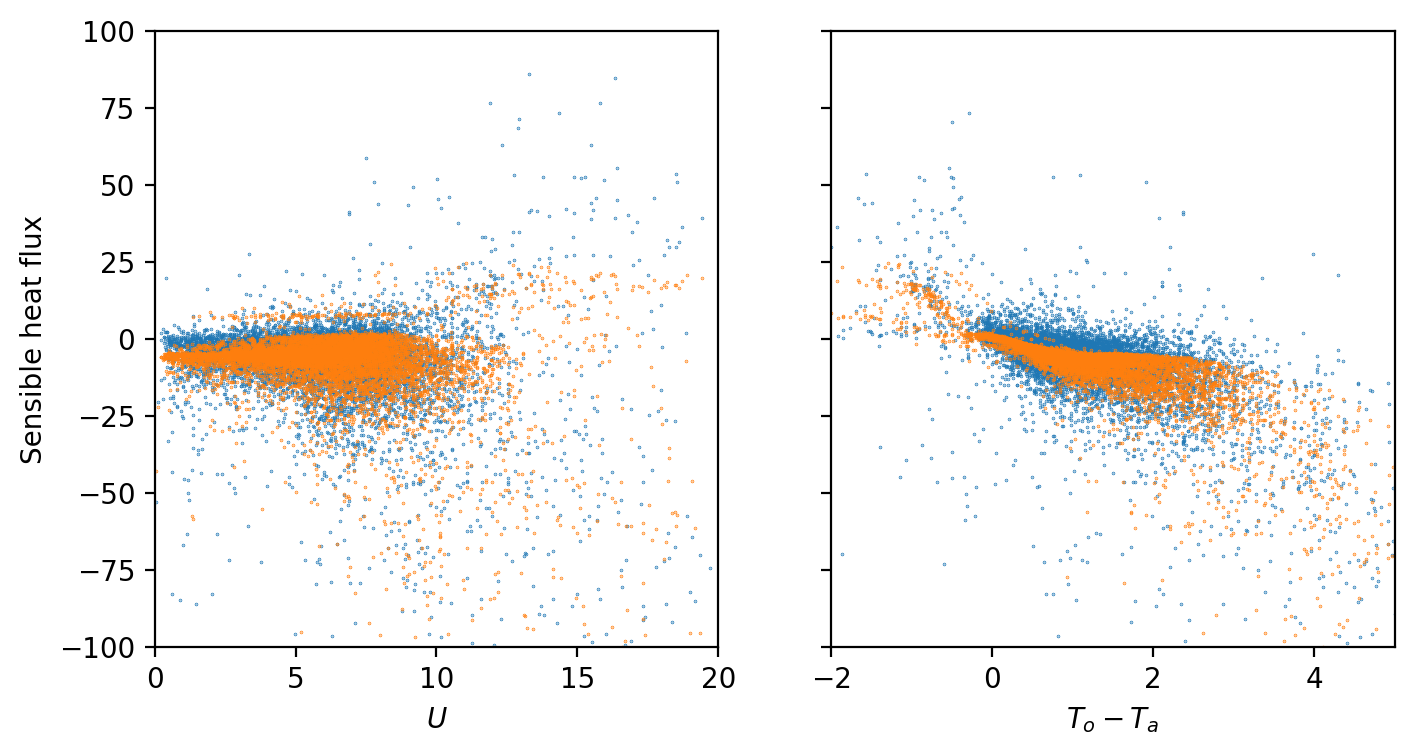

In [22]:
fig, axes = plt.subplots(1,2, figsize=[8,4], dpi=200, sharey=True)
ax = axes[0]
ax.plot(training_data.X[:,0],training_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(training_data.X)
ax.plot(training_data.X[:,0],Y_pred.detach(), '.', markersize=0.5)
ax.set_ylim([-100,100]); ax.set_xlim([0,20])
ax.set_xlabel('$U$'); ax.set_ylabel('Sensible heat flux')

ax = axes[1]
ax.plot(training_data.X[:,1]-training_data.X[:,2],training_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(training_data.X)
ax.plot(training_data.X[:,1]-training_data.X[:,2],Y_pred.detach(), '.', markersize=0.5)
ax.set_ylim([-100,100]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_o-T_a$'); 

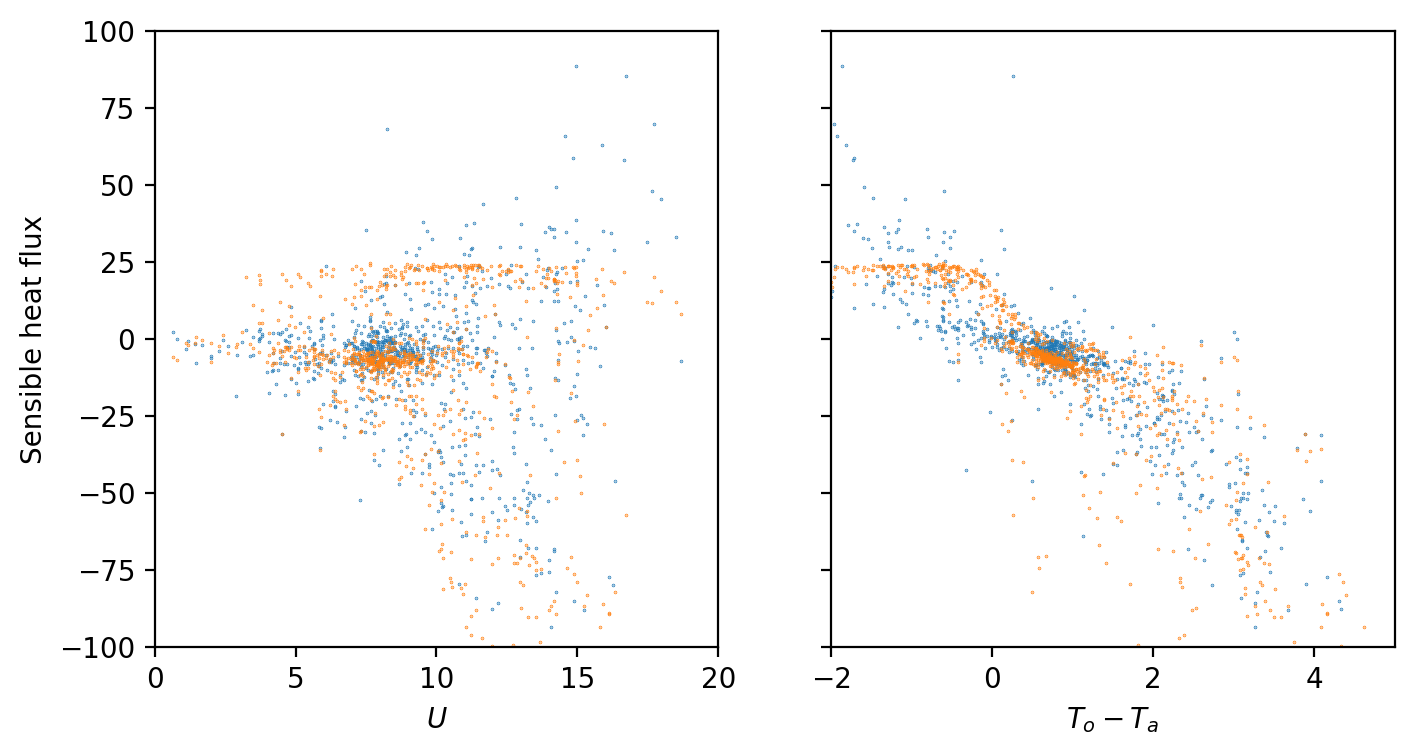

In [23]:
fig, axes = plt.subplots(1,2, figsize=[8,4], dpi=200, sharey=True)
ax = axes[0]
ax.plot(testing_data.X[:,0],testing_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(testing_data.X)
ax.plot(testing_data.X[:,0],Y_pred.detach(), '.', markersize=0.5)
ax.set_ylim([-100,100]); ax.set_xlim([0,20])
ax.set_xlabel('$U$'); ax.set_ylabel('Sensible heat flux')

ax = axes[1]
ax.plot(testing_data.X[:,1]-testing_data.X[:,2],testing_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(testing_data.X)
ax.plot(testing_data.X[:,1]-testing_data.X[:,2],Y_pred.detach(), '.', markersize=0.5)
ax.set_ylim([-100,100]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_o-T_a$'); 

Text(0, 0.5, 'Sensible heat flux')

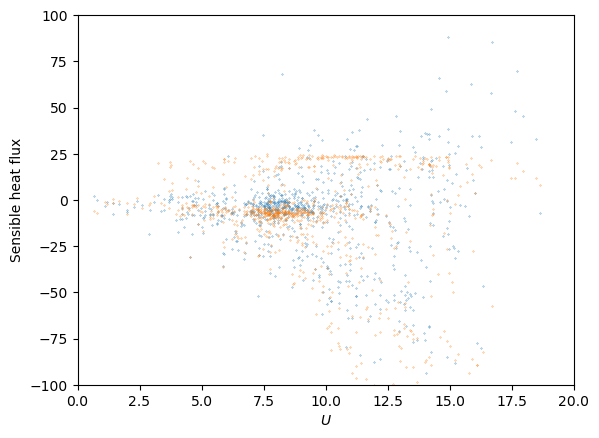

In [13]:
plt.plot(testing_data.X[:,0],testing_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(testing_data.X)
plt.plot(testing_data.X[:,0],Y_pred.detach(), '.', markersize=0.5)
ax = plt.gca()
ax.set_ylim([-100,100]); ax.set_xlim([0,20])
ax.set_xlabel('$U$'); ax.set_ylabel('Sensible heat flux')

In [63]:
training_data.Y.var()

tensor(515.6978)

In [64]:
validating_data.Y.var()

tensor(334.3766)

### 1.2 - Three inputs, without transform layer


### 2.1 Only pass in temperature difference


In [ ]:

class Flux21(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,1]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2
        scale = torch.tensor(np.array([20,1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([-8]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([20.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
        x1_mesh, x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')
        X_uniform = np.hstack([x1_mesh.reshape(-1,1), x2_mesh.reshape(-1,1)])
        X_uniform = torch.tensor(X_uniform.astype('float32'))
        mean_uniform = self.pred_mean(X_uniform).detach().reshape(100,100)
        var_uniform = self.pred_var(X_uniform).detach().reshape(100,100)
        return (mean_uniform, var_uniform)

In [ ]:
''' 2D input (wind speed, temp difference) - 1D output (heat flux)
'''

# Right now do it like this
from torch.utils.data import Dataset
class RealFluxDatasetVar(Dataset):
    def __init__(self, ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','hsc','hlc'], 
                 weightfunc=sample_weights):
        
        # Assemble input and output features
        self.X = torch.tensor(np.hstack([ds['U'].values.reshape(-1,1),
                                         (ds['tsea']-ds['tair']).values.reshape(-1,1)]).astype('float32'))
        self.Y = torch.tensor(np.hstack([ds['hsc'].values.reshape(-1,1),]).astype('float32'))
            
        # Weights according to weightfunc of choice
        # TODO: only depends on wind. How to write this better?
        self.W = torch.tensor(weightfunc(self.X[:,0]).astype('float32'))
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.W[idx]

# Initiate the Dataset class and use default weighting
para1 = {'n_in':2,'n_out':1,'hidden_channels':[16]}
para2 = {'n_in':2,'n_out':1,'hidden_channels':[16]}
model = Flux21({'mean_ann_para':para1, 'var_ann_para':para2})

training_data = RealFluxDatasetVar(training_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)
validating_data = RealFluxDatasetVar(validating_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)




### 2.1 Pass in temperature difference, as well as absolute temperature